# Figures

Code used to produce the figures in the paper:

- [Figure 2](#quantity-skew)
- [Figure 3](#label-skew)
- [Figure 4](#vertical-partitioning)
- [Figure 5](#natural-partition-result-table)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import data

import scienceplots
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
plt.style.use('science')

os.makedirs('figs', exist_ok = True)

def set_self_importance(df):
    """Set self-importance as the importance each client gives to its own base model"""
    stack_on = 'validation' 
    for i, row in df.iterrows():
        island = row['island']
        
        self_imp_on_validation = row[f'imp_on_validation_{island}']
        self_imp_on_pooled = row[f'imp_on_pooled_{island}']

        df.loc[i, f'self_imp_on_{stack_on}'] = self_imp_on_validation
        df.loc[i, f'self_imp_on_pooled'] = self_imp_on_pooled


def set_importances(df, n_islands = 10):
    """Aggregate contribution scores to set client importance"""

    for on in 'validation', 'pooled':
        imp_cols = [f'imp_on_{on}_{i}' for i in range(n_islands)]
        # Iterative over chunks of n_islands rows of df
        for i in range(0, df.shape[0], n_islands):
            subset = df.iloc[i:i+n_islands][['island'] + imp_cols]    
            importances = subset[imp_cols].sum() / subset[imp_cols].sum().sum()
            importances.index = range(i, i+n_islands)
            df.loc[i:i+n_islands, f'imp_on_{on}'] = importances

    set_self_importance(df)

def format_columns_and_data(df):
    
    # Rename columns
    df = df.rename(columns = {'data': 'Dataset', 'island': 'Client', 'n_fraction': 'N (%)'})

    # Format Dataset column
    df['Dataset'] = df['Dataset'].replace('vehicle-loan-default', 'Vehicle Loan')
    df['Dataset'] = df['Dataset'].str.title()

    return df
    

def results_df(dir):
    """Merges all csv files in dir into a single dataframe"""
    fnames = sorted(filter(lambda f: f.endswith('.csv'),  os.listdir(dir)), key = lambda f: int(f.split('.')[0]))
    df = pd.concat([pd.read_csv(os.path.join(dir, f)) for f in fnames])
    df = df.reset_index(drop=True)
    return df

In [2]:
METRIC = 'Balanced Accuracy' # 'ROC AUC', 'Accuracy', 'Balanced Accuracy'
n_islands = 10

### Natural partition result table

In [3]:
natural = results_df('results/natural')
natural['island'] = natural['island'].astype('object')

# Check we have the correct data
gb = natural.groupby(['data', 'random_state'])['island'].count()
assert gb.shape[0] == 3 * 10 # 3 datasets, 10 random states


set_importances(natural)
natural = format_columns_and_data(natural)

natural = natural.rename(columns = {
    f'stack_on_validation_delta_{METRIC}_mean': 'Gain by stacking on validation',
    f'stack_on_pooled_delta_{METRIC}_mean': 'Gain by stacking on pooled'
})

# Fix covertype y_mean mistake (see Label Skew section below)
covertype_ix = natural[natural['Dataset'] == 'Covertype'].index
natural.loc[covertype_ix, 'y_mean'] = natural.loc[covertype_ix]['y_mean'] - 1


cols = ['Dataset', 'Client', 'N (%)', 'Gain by stacking on validation', 'Gain by stacking on pooled']

stds = tmp = natural.groupby(['Dataset', 'Client'], as_index = False)[cols].std(numeric_only = True)
tmp = natural.groupby(['Dataset', 'Client'], as_index = False)[cols].mean(numeric_only = True)

tmp['Delta'] = tmp['Gain by stacking on validation'] - tmp['Gain by stacking on pooled']

round_column = lambda df, col, decimals = 2: df[col].apply(lambda x: f'{x:.{decimals}f}')

tmp['Gain by stacking on validation'] = round_column(tmp, 'Gain by stacking on validation', 3)
stds['Gain by stacking on validation'] = round_column(stds, 'Gain by stacking on validation', 3)

tmp['Gain by stacking on pooled'] = round_column(tmp, 'Gain by stacking on pooled', 3)
stds['Gain by stacking on pooled'] = round_column(stds, 'Gain by stacking on pooled', 3)


tmp['Delta'] = tmp['Delta'].apply(lambda x: f'{x:.{3}f}') #lambda x: round(x, 3))
tmp['N (%)'] = tmp['N (%)'].apply(lambda x: f'{100 * x:.{1}f}') #round(x * 100, 1))

tmp['Dataset'] = tmp['Dataset'].replace('vehicle-loan-default', 'Vehicle Loan')
tmp['Dataset'] = tmp['Dataset'].str.title()

census = {0:'US', 1:'Latin America', 2:'Asia', 3:'Europe'}
covertype = {0:'Comanche', 1:'Neota', 2:'Rawah'}
for dataset, d in zip(['Census', 'Covertype'], [census, covertype]):
    ix = tmp[tmp['Dataset'] == dataset].index
    tmp.loc[ix, 'Client'] = tmp.loc[ix, 'Client'].replace(d)

tmp = tmp.sort_values(['Dataset', 'N (%)'], ascending=[True, False])
tmp.to_csv('figs/natural_table.csv', index = False)

# Add stds for appendix
tmp = tmp.reset_index(drop = True)
tmp['t'] = tmp['Gain by stacking on validation'].astype(str) + ' ± ' +  (stds['Gain by stacking on validation']).astype(str)
tmp['Gain by stacking on validation'] = tmp['t'].copy()
tmp['t'] = tmp['Gain by stacking on pooled'].astype(str) + ' ± ' +  (stds['Gain by stacking on pooled']).astype(str)
tmp['Gain by stacking on pooled'] = tmp['t'].copy()

tmp[cols].to_csv('figs/natural_table_with_stds.csv', index = False)

# tmp


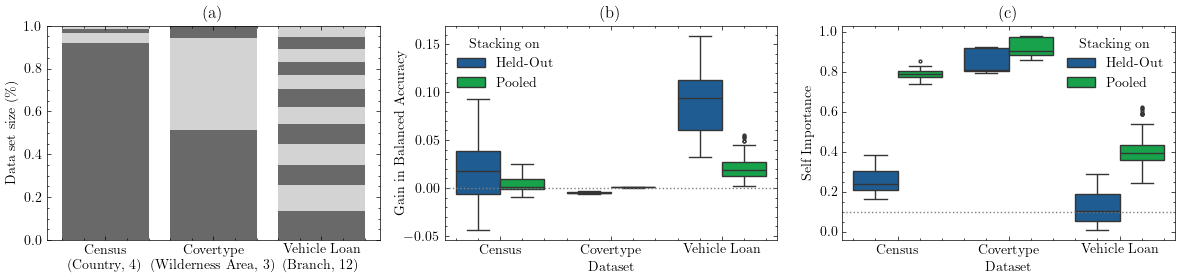

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 3))

gb = natural.groupby(['Dataset', 'Client'], as_index = False)['N (%)'].first()
gb = gb.sort_values(['Dataset', 'N (%)'], ascending = False)

gb['Dataset'] = gb['Dataset'].replace({
    'Census': 'Census\n(Country, 4)',
    'Covertype': 'Covertype\n(Wilderness Area, 3)',
    'Vehicle Loan': 'Vehicle Loan\n(Branch, 12)'
})


x = gb['Dataset'].unique()

acc = pd.Series({d:0 for d in x})

for d in x:

    for i, n in enumerate(gb[gb['Dataset'] == d]['N (%)']):

        tmp = pd.Series({d_i:0 if d_i != d else n for d_i in x})
        tmp[d] = n

        tmp.sort_index(inplace = True)
        acc.sort_index(inplace = True)

        ax1.bar(tmp.index, tmp, bottom = acc, color = 'dimgray' if i % 2 == 0 else 'lightgrey')
        acc += tmp

ax1.set_ylabel('Data set size (\%)')
ax1.set_title('(a)')


df = natural
cols = ['Gain by stacking on validation', 'Gain by stacking on pooled']
tmp = df.melt(id_vars = ['Dataset', 'Client'], value_vars = cols)
tmp['variable'] = tmp['variable'].apply(lambda x: x.split()[-1].title())
tmp.rename(columns = {'value': 'Gain by stacking', 'variable': 'Stacking on'}, inplace = True)
tmp['Stacking on'] = tmp['Stacking on'].replace({'Validation': 'Held-Out'})

sns.boxplot(data = tmp, x = 'Dataset', y = 'Gain by stacking', hue = 'Stacking on', fliersize = 2, ax = ax2)
ax2.axhline(0, color = 'grey', linestyle = ':')
ax2.set_title('(b)')
ax2.set_ylabel(f'Gain in {METRIC}', labelpad = -2)

df = natural
cols = ['self_imp_on_validation', 'self_imp_on_pooled']
tmp = df.melt(id_vars = ['Dataset', 'Client'], value_vars = cols)
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[-1].title())
tmp.rename(columns = {'value': 'Self Importance', 'variable': 'Stacking on'}, inplace = True)
tmp['Stacking on'] = tmp['Stacking on'].replace({'Validation': 'Held-Out'})

sns.boxplot(data = tmp, x = 'Dataset', y = 'Self Importance', hue = 'Stacking on', fliersize = 2, ax = ax3)
ax3.axhline(1 / n_islands, color = 'grey', linestyle = ':')
ax3.set_title('(c)')

f.tight_layout()
f.savefig('figs/natural.jpg', bbox_inches = 'tight', dpi = 300)


## Quantity Skew 

In [7]:
power = results_df('results/power')

# Check we have the correct data
gb = power.groupby(['data', 'a', 'random_state'])['island'].count()
assert (gb == 10).all() and gb.shape[0] == 3 * 4 * 10 # 3 datasets, 4 a's, 10 random states


set_importances(power)
power = format_columns_and_data(power)

# To bin N (%) values
vs, edges = np.histogram(power['N (%)'])
edges = [e for v, e in zip(vs, edges) if v > 0]
edges.append(power['N (%)'].max())
power['binned N (%)'] = pd.cut(power['N (%)'], bins = edges, labels = [(edges[i] + edges[i+1])/2 for i in range(len(edges) - 1)])

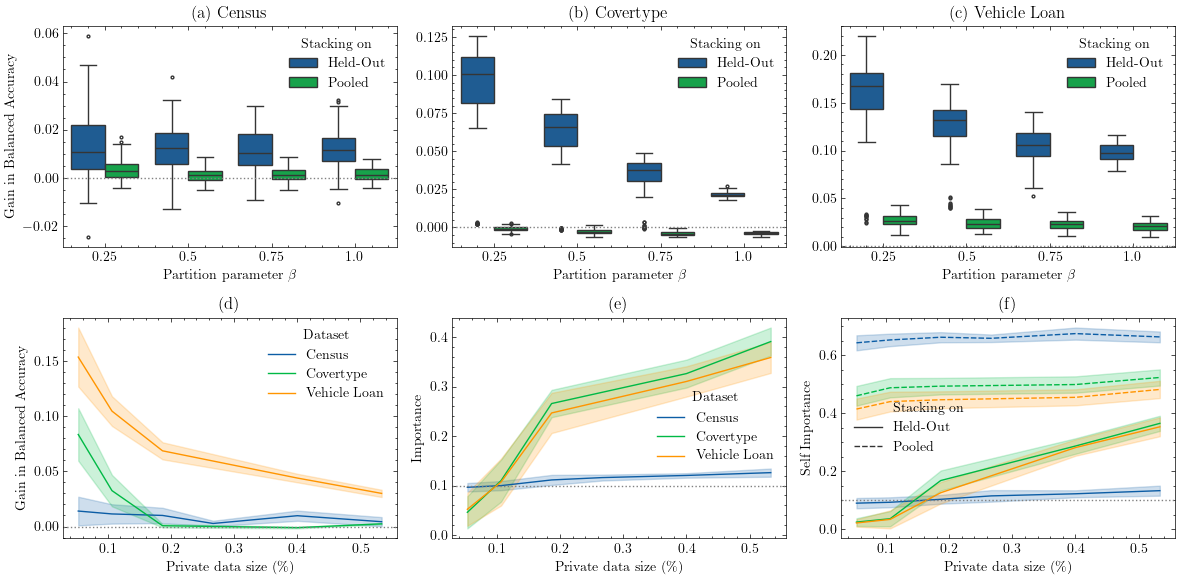

In [9]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (12, 3*2))

# Boxplots Gain in metric vs. a
df = power
param = 'a'

cols = [f'stack_on_validation_delta_{METRIC}_mean', f'stack_on_pooled_delta_{METRIC}_mean']
tmp = df.melt(id_vars = ['Dataset', 'Client', param], value_vars = cols)
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[2].title())
tmp.rename(columns = {'value': 'Gain by stacking', 'variable': 'Stacking on'}, inplace = True)
tmp['Stacking on'] = tmp['Stacking on'].replace({'Validation': 'Held-Out'})

for ax, letter, dataset in zip([ax1, ax2, ax3], ['a', 'b', 'c'], df['Dataset'].unique()):

    sns.boxplot(data = tmp[tmp['Dataset'] == dataset], x = param, y = 'Gain by stacking', hue = 'Stacking on', fliersize = 2, ax = ax)
    ax.axhline(0, color = 'grey', linestyle = ':')
    ax.set_title(f'({letter}) {dataset}')
    ax.set_ylabel('')
    ax.set_xlabel('Partition parameter $\\beta$') # to avoid confusion with 'a'

ax1.set_ylabel(f'Gain in {METRIC}') #, labelpad = -2, fontsize = 'large')


# Lineplots N (%) vs. Gain in metric

# Set self-importance with Stacking on as a column
df = power
param = 'binned N (%)'
cols = ['self_imp_on_validation', 'self_imp_on_pooled']
tmp = df.melt(id_vars = ['Dataset', 'Client', param], value_vars = cols)
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[-1].title())
tmp.rename(columns = {'value': f'Self Importance', 'variable': 'Stacking on'}, inplace = True)
tmp['Stacking on'] = tmp['Stacking on'].replace({'Validation': 'Held-Out'})

sns.lineplot(data = power, x = 'binned N (%)', y = f'stack_on_validation_delta_{METRIC}_mean', hue = 'Dataset', errorbar = 'sd', ax = ax4)
ax4.axhline(0, color = 'grey', linestyle = ':')
ax4.set_ylabel(f'Gain in {METRIC}')
ax4.set_title('(d)')
ax4.set_xlabel('Private data size (\%)')


sns.lineplot(data = power, x = 'binned N (%)', y = f'imp_on_validation', hue = 'Dataset', errorbar = 'sd', ax = ax5)
ax5.axhline(1 / n_islands, color = 'grey', linestyle = ':')
ax5.set_title('(e)')
ax5.set_ylabel(f'Importance')
ax5.set_xlabel('Private data size (\%)')

sns.lineplot(data = tmp, x = 'binned N (%)', y = f'Self Importance', hue = 'Dataset', style = 'Stacking on', errorbar = 'sd', ax = ax6)
ax6.axhline(1 / n_islands, color = 'grey', linestyle = ':')
ax6.set_title('(f)')
ax6.set_ylabel(f'Self Importance')
ax6.set_xlabel('Private data size (\%)')
h, l = ax6.get_legend_handles_labels()
ax6.legend(h[-3:], l[-3:], loc = 'center left')

f.tight_layout()
f.savefig('figs/power.jpg', bbox_inches = 'tight', dpi = 300)


## Label Skew

In [10]:
dirichlet = results_df('results/dirichlet')

# Check we have the correct data
gb = dirichlet.groupby(['data', 'alpha', 'random_state'])['island'].count()
assert (gb == 10).all() and gb.shape[0] == 3 * 4 * 10 # 3 datasets, 4 alphas, 10 random states

set_importances(dirichlet)
dirichlet = format_columns_and_data(dirichlet)

# Correction for Covertype's y_mean. We did not set the classes to be 0 and 1 in the preprocessing step.
# Instead they are 1 and 2. We correct this here. The y mean column will be the prop. of class 2. 
covertype_ix = dirichlet[dirichlet['Dataset'] == 'Covertype'].index
dirichlet.loc[covertype_ix, 'y_mean'] = dirichlet.loc[covertype_ix]['y_mean'] - 1

# To bin y_mean values
edges = np.arange(0, 1.1, 0.1)
dirichlet['binned y_mean'] = pd.cut(dirichlet['y_mean'], bins = edges, labels = [round((edges[i] + edges[i+1])/2, 2) for i in range(len(edges) - 1)])

In [11]:
# For the heatmap
# Want a list of (y_mean_1, y_mean_2, importance 1 assigns to 2)

df = dirichlet
n_islands = 10
on = 'validation'
imp_cols = [f'imp_on_{on}_{i}' for i in range(n_islands)]

out = []

# Iterative over chunks of n_islands rows of df
for i in range(0, df.shape[0], n_islands):

    subset = df.iloc[i:i+n_islands]
    y_means = subset.groupby('Client')['binned y_mean'].first().to_dict()
    
    for j, row in subset.iterrows():
        
        current = row['Client']
        for other in range(n_islands):
            out.append((row['Dataset'], y_means[current], y_means[other], row[f'imp_on_{on}_{other}']))

out = pd.DataFrame(out, columns = ['Dataset', 'y_mean_current', 'y_mean_other', 'importance'])

# Multiply importance by 100 and round to 2 decimals
out['importance'] = out['importance'] * 100
out['importance'] = out['importance'].apply(lambda x: round(x, 2))

# Remove first 0 from y_mean_current and y_mean_other for the heatmap
out['y_mean_current'] = out['y_mean_current'].apply(lambda x: f'{str(x)[1:]}')
out['y_mean_other'] = out['y_mean_other'].apply(lambda x: f'{str(x)[1:]}')

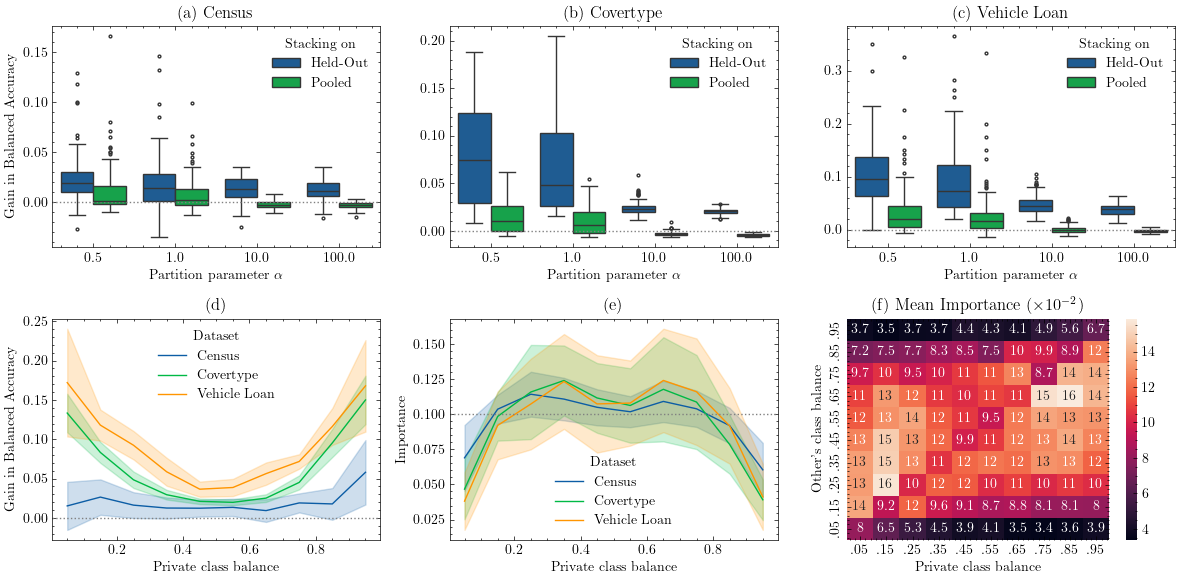

In [12]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (12, 3 * 2))


# Boxplots Gain in metric vs. alpha
df = dirichlet
param = 'alpha'

cols = [f'stack_on_validation_delta_{METRIC}_mean', f'stack_on_pooled_delta_{METRIC}_mean']
tmp = df.melt(id_vars = ['Dataset', 'Client', param], value_vars = cols)
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[2].title())
tmp.rename(columns = {'value': 'Gain by stacking', 'variable': 'Stacking on'}, inplace = True)
tmp['Stacking on'] = tmp['Stacking on'].replace({'Validation': 'Held-Out'})

for ax, letter, dataset in zip([ax1, ax2, ax3], 'abc', df['Dataset'].unique()):

    sns.boxplot(data = tmp[tmp['Dataset'] == dataset], x = param, y = 'Gain by stacking', hue = 'Stacking on', fliersize = 2, ax = ax)
    ax.axhline(0, color = 'grey', linestyle = ':')
    ax.set_title(f'({letter}) {dataset}')
    ax.set_ylabel('')
    ax.set_xlabel('Partition parameter $\\alpha$')

ax1.set_ylabel(f'Gain in {METRIC}')


# Lineplots y_mean vs. Gain in metric
sns.lineplot(data = dirichlet, x = 'binned y_mean', y = f'stack_on_validation_delta_{METRIC}_mean', hue = 'Dataset', errorbar = 'sd', ax = ax4)
ax4.axhline(0, color = 'grey', linestyle = ':')
ax4.set_ylabel(f'Gain in {METRIC}')
ax4.set_title('(d)')
ax4.set_xlabel('Private class balance')


sns.lineplot(data = dirichlet, x = 'binned y_mean', y = 'imp_on_validation', hue = 'Dataset', errorbar = 'sd', ax = ax5)
ax5.axhline(1 / n_islands, color = 'grey', linestyle = ':')
ax5.set_title('(e)')
ax5.set_ylabel(f'Importance')
ax5.set_xlabel('Private class balance')

tmp = out.groupby(['y_mean_other', 'y_mean_current'])['importance'].mean()
sns.heatmap(tmp.unstack(), annot = True, ax = ax6)
ax6.set_title('(f) Mean Importance ($\\times 10^{-2}$)')
ax6.set_xlabel('Private class balance')
ax6.set_ylabel('Other\'s class balance')
ax6.invert_yaxis()

f.tight_layout()
f.savefig('figs/dirichlet.jpg', bbox_inches = 'tight', dpi = 300)

## Vertical partitioning

In [15]:
vertical = results_df('results/vertical')


gb = vertical.groupby(['data', 'prop_cols', 'eps', 'random_state'])['island'].count()
assert (gb == 10).all() and gb.shape[0] == 3 * 3 * 5 * 10 # 3 datasets, 3 prop_cols's, 5 eps, 10 random states

set_importances(vertical)
vertical = format_columns_and_data(vertical)
# vertical = vertical[vertical['Dataset'] == 'Covertype']

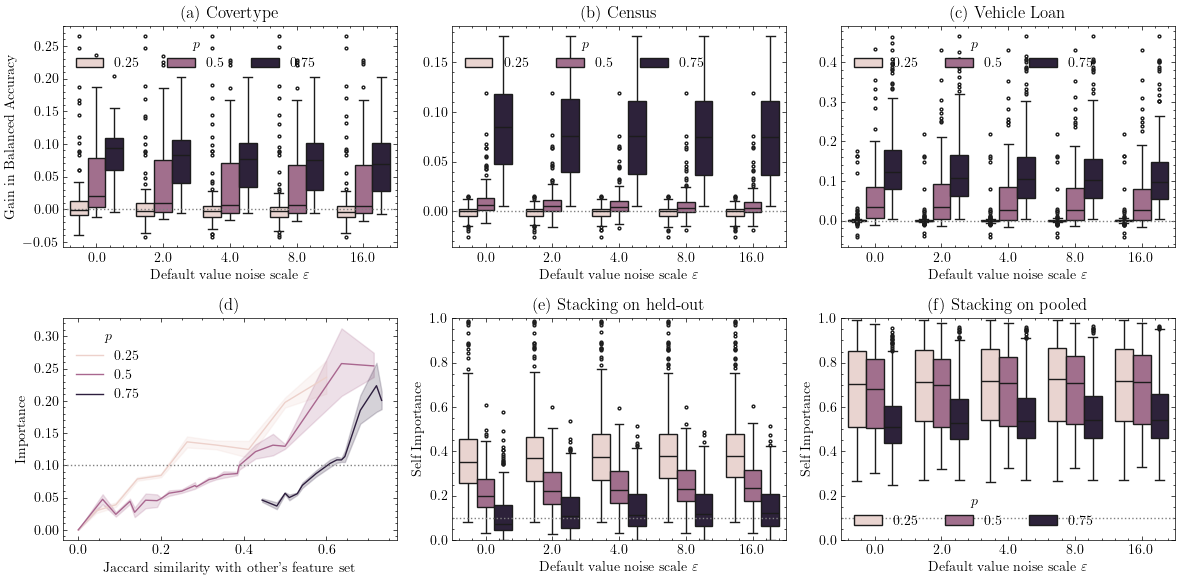

In [16]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (12, 3 * 2))

for ax, dataset, l in zip([ax1, ax2, ax3], vertical['Dataset'].unique(), 'abc'):
    sns.boxplot(data = vertical[vertical['Dataset'] == dataset], x = 'eps', y = f'stack_on_validation_delta_{METRIC}_mean', hue = 'prop_cols', fliersize = 2, ax = ax)
    ax.axhline(0, color = 'grey', linestyle = ':')
    ax.set_ylabel('')
    ax.set_xlabel('Default value noise scale $\\varepsilon$')
    ax.set_title(f'({l}) {dataset}')
    ax.legend(title = '$p$', loc = 'upper left', ncol = 3)

ax1.set_ylabel(f'Gain in {METRIC}')

out = []
for ix, row in vertical.iterrows():  
    for i in range(n_islands):
        if i == row['Client']: continue
        out.append((row['Dataset'], row['eps'], row['prop_cols'], row[f'imp_on_validation_{i}'], row[f'jaccard_{i}']))#, row['avg_jaccard'], row['max_jaccard']))

out = pd.DataFrame(out, columns = ['Dataset', 'eps', 'p', 'importance', 'jaccard'])#, 'avg_jaccard', 'max_jaccard'])

# Bin jaccard into 10 bins
edges = np.arange(0, 1.1, 0.1)
out['binned jaccard'] = pd.cut(out['jaccard'], bins = edges, labels = [round((edges[i] + edges[i+1])/2, 2) for i in range(len(edges) - 1)])

# The have very few jaccard sims over 0.75, so we remove them
sns.lineplot(data = out[out['jaccard'] < 0.75], x = 'jaccard', y = 'importance', hue = 'p', ax = ax4)
ax4.axhline(1 / n_islands, color = 'grey', linestyle = ':')
ax4.set_title('(d)')
ax4.set_ylabel('Importance')
ax4.set_xlabel('Jaccard similarity with other\'s feature set')
ax4.legend(title = '$p$')

for stacking_on, ax, l in zip(['validation', 'pooled'], [ax5, ax6], 'ef'):

    sns.boxplot(data = vertical, x = 'eps', y = f'self_imp_on_{stacking_on}', hue = 'prop_cols', fliersize = 2, ax = ax)
    ax.axhline(1 / n_islands, color = 'grey', linestyle = ':')
    ax.set_ylim(0, 1.0)
    ax.set_ylabel('Self Importance')
    ax.set_xlabel('Default value noise scale $\\varepsilon$')
    stacking_on = 'held-out' if stacking_on == 'validation' else 'pooled'
    ax.set_title(f'({l}) Stacking on {stacking_on}')

ax5.get_legend().set_visible(False)
ax6.legend(title = '$p$', loc = 'lower left', ncol = 3)

f.tight_layout()
f.savefig('figs/vertical_main.jpg', bbox_inches = 'tight', dpi = 300)

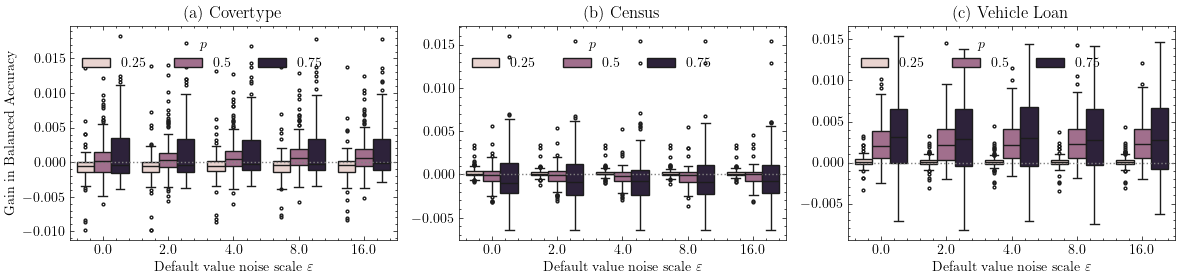

In [47]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (12, 3 * 1))

for ax, dataset, l in zip([ax1, ax2, ax3], vertical['Dataset'].unique(), 'abc'):
    sns.boxplot(data = vertical[vertical['Dataset'] == dataset], x = 'eps', y = f'stack_on_pooled_delta_{METRIC}_mean', hue = 'prop_cols', fliersize = 2, ax = ax)
    ax.axhline(0, color = 'grey', linestyle = ':')
    ax.set_ylabel('')
    ax.set_xlabel('Default value noise scale $\\varepsilon$')
    ax.set_title(f'({l}) {dataset}')
    ax.legend(title = '$p$', loc = 'upper left', ncol = 3)

ax1.set_ylabel(f'Gain in {METRIC}')

f.tight_layout()
f.savefig('figs/vertical_appendix.jpg', bbox_inches = 'tight', dpi = 300)